# Explore Data

## Import libraries

In [1]:
import boto3
import matplotlib.pyplot as plt
import os
import pandas as pd
import sagemaker
import seaborn as sns
import warnings

from pyathena import connect

# set theme for seaborn
sns.set_theme()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filter out the specific UserWarning related to DBAPI2 objects
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# check stored variables
%store

Stored variables and their in-db values:
account_id                                -> '453322325373'
boto_session                              -> '<unavailable>'
bucket_name                               -> 'housing-dataset-8578'
df_test_saved_to_s3                       -> 's3://housing-dataset-8749/processed/housing/test.
df_train_saved_to_s3                      -> 's3://housing-dataset-8749/processed/housing/train
df_validation_saved_to_s3                 -> 's3://housing-dataset-8749/processed/housing/valid
estimator                                 -> '<unavailable>'
feature_store_session                     -> '<unavailable>'
featurestore_runtime                      -> '<unavailable>'
model_name                                -> 'sagemaker-xgboost-2024-06-24-05-19-43'
output_path                               -> 's3://housing-dataset-8749/housing/model'
predictor                                 -> '<unavailable>'
region                                    -> 'us-east-1'
role     

## Pull Data from Athena

In [3]:
# save Amazon information
account_id = boto3.client("sts").get_caller_identity().get("Account")
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3', region_name=sagemaker_session.boto_region_name)

In [4]:
# get bucket_name
%store -r bucket_name
print(bucket_name)

# set S3 staging directory
s3_staging_dir = "s3://{0}/athena/staging".format(bucket_name)

# create connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

housing-dataset-8578


In [5]:
# set database name and table name
database_name = "housing"
table_name = "data"

# pull data
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)
df = pd.read_sql(statement, conn)
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,,Reg,Lvl,AllPub,...,0,,,,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,,Reg,Lvl,AllPub,...,0,,,,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,,IR1,Lvl,AllPub,...,0,,,,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,,IR1,Lvl,AllPub,...,0,,,,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,,IR1,Lvl,AllPub,...,0,,,,0,12,2008,WD,Normal,250000.0


## Explore Data

### Review Target Column

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64


<Figure size 700x600 with 0 Axes>

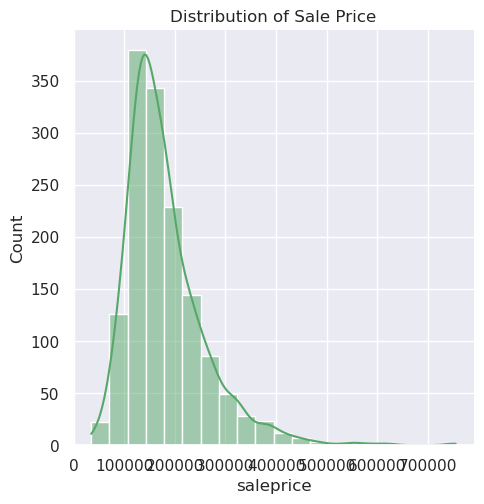

In [6]:
# review target column of saleprice
print(df['saleprice'].describe())
plt.figure(figsize=(7, 6))
sns.displot(df['saleprice'], bins=20, kde=True, color='g')
plt.title(f'Distribution of Sale Price')
plt.show()

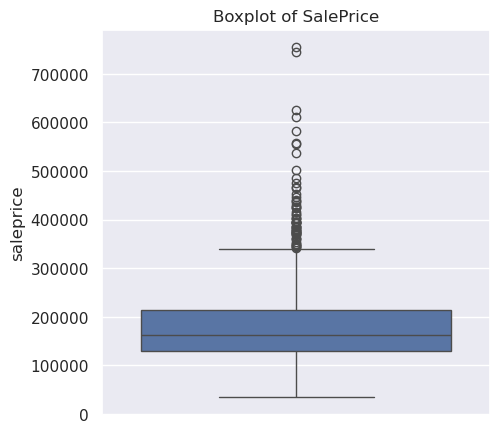

In [7]:
# Plot a boxplot to examine the number of outliers
plt.figure(figsize=(5, 5))
sns.boxplot(df['saleprice'])
plt.title('Boxplot of SalePrice')
plt.xticks(rotation=45)
plt.show()

### Review Numerical Columns

In [8]:
# select only the numerical features
df_num = df.select_dtypes(include = ['float64', 'int64'])

# drop Id and SalePrice columns
df_num = df_num.drop('id', axis=1)
df_num = df_num.drop('saleprice', axis=1)

# print shape of dataset
shape = df_num.shape
print("Shape of the dataframe (row, col):",shape,"\r\n")

# show first 5 rows of data frame
df_num.head()

Shape of the dataframe (row, col): (2919, 36) 



,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


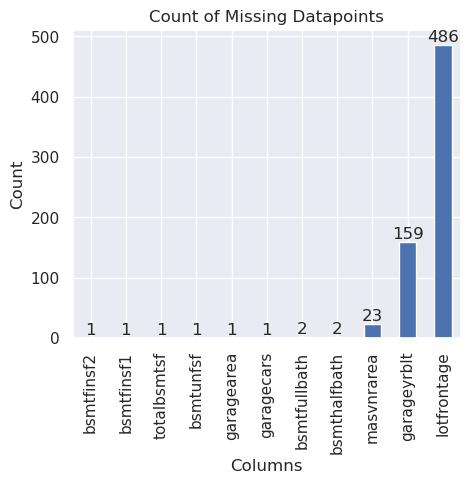

In [9]:
# find and plot how many missing values each column has
missing = df_num.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

plt.figure(figsize=(5, 4))
missing.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Count of Missing Datapoints')

# Displaying the count of the bars above each bar
for i, v in enumerate(missing):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [10]:
# Statistics on years
print("The earliest house was built in {}, and the most recent house was built in {}.".format(min(df['yearbuilt']), max(df['yearbuilt'])))
print("They started adding a garage in {} up until {}.".format(min(df['garageyrblt']), max(df['garageyrblt'])))
print("They also started remodeling in {} up until {}.".format(min(df['yearremodadd']), max(df['yearremodadd'])))
print("The houses were sold from {} up until {}.".format(min(df['yrsold']), max(df['yrsold'])))

The earliest house was built in 1872, and the most recent house was built in 2010.
They started adding a garage in 1895.0 up until 2207.0.
They also started remodeling in 1950 up until 2010.
The houses were sold from 2006 up until 2010.


In [11]:
print("The average overall quality of the house is {} and ranges from {} to {}.".format(round(df['overallqual'].mean(),2), min(df['overallqual']),
                                                                                        max(df['overallqual'])))
print("Similarly, the average overall condition of the house is {} and ranges from {} to {}.".format(round(df['overallcond'].mean(),2),
                                                                                                     min(df['overallcond']),
                                                                                                     max(df['overallcond'])))

The average overall quality of the house is 6.09 and ranges from 1 to 10.
Similarly, the average overall condition of the house is 5.56 and ranges from 1 to 9.


Text(0.5, 1.0, 'Size of garage in square feet')

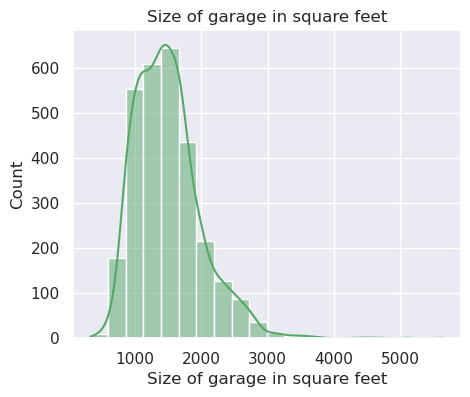

In [12]:
# plot garage square footage
plt.figure(figsize=(5, 4))
sns.histplot(df['grlivarea'], bins=20, kde=True, color='g')
plt.xlabel('Size of garage in square feet')
plt.ylabel('Count')
plt.title('Size of garage in square feet')

Text(0.5, 1.0, 'Size of lot in square feet')

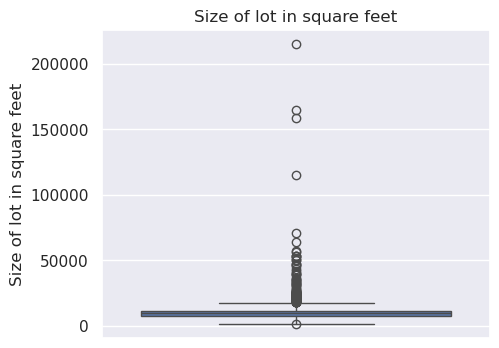

In [13]:
# plot lot area
plt.figure(figsize=(5, 4))
sns.boxplot(df['lotarea'])
plt.ylabel('Size of lot in square feet')
plt.title('Size of lot in square feet')

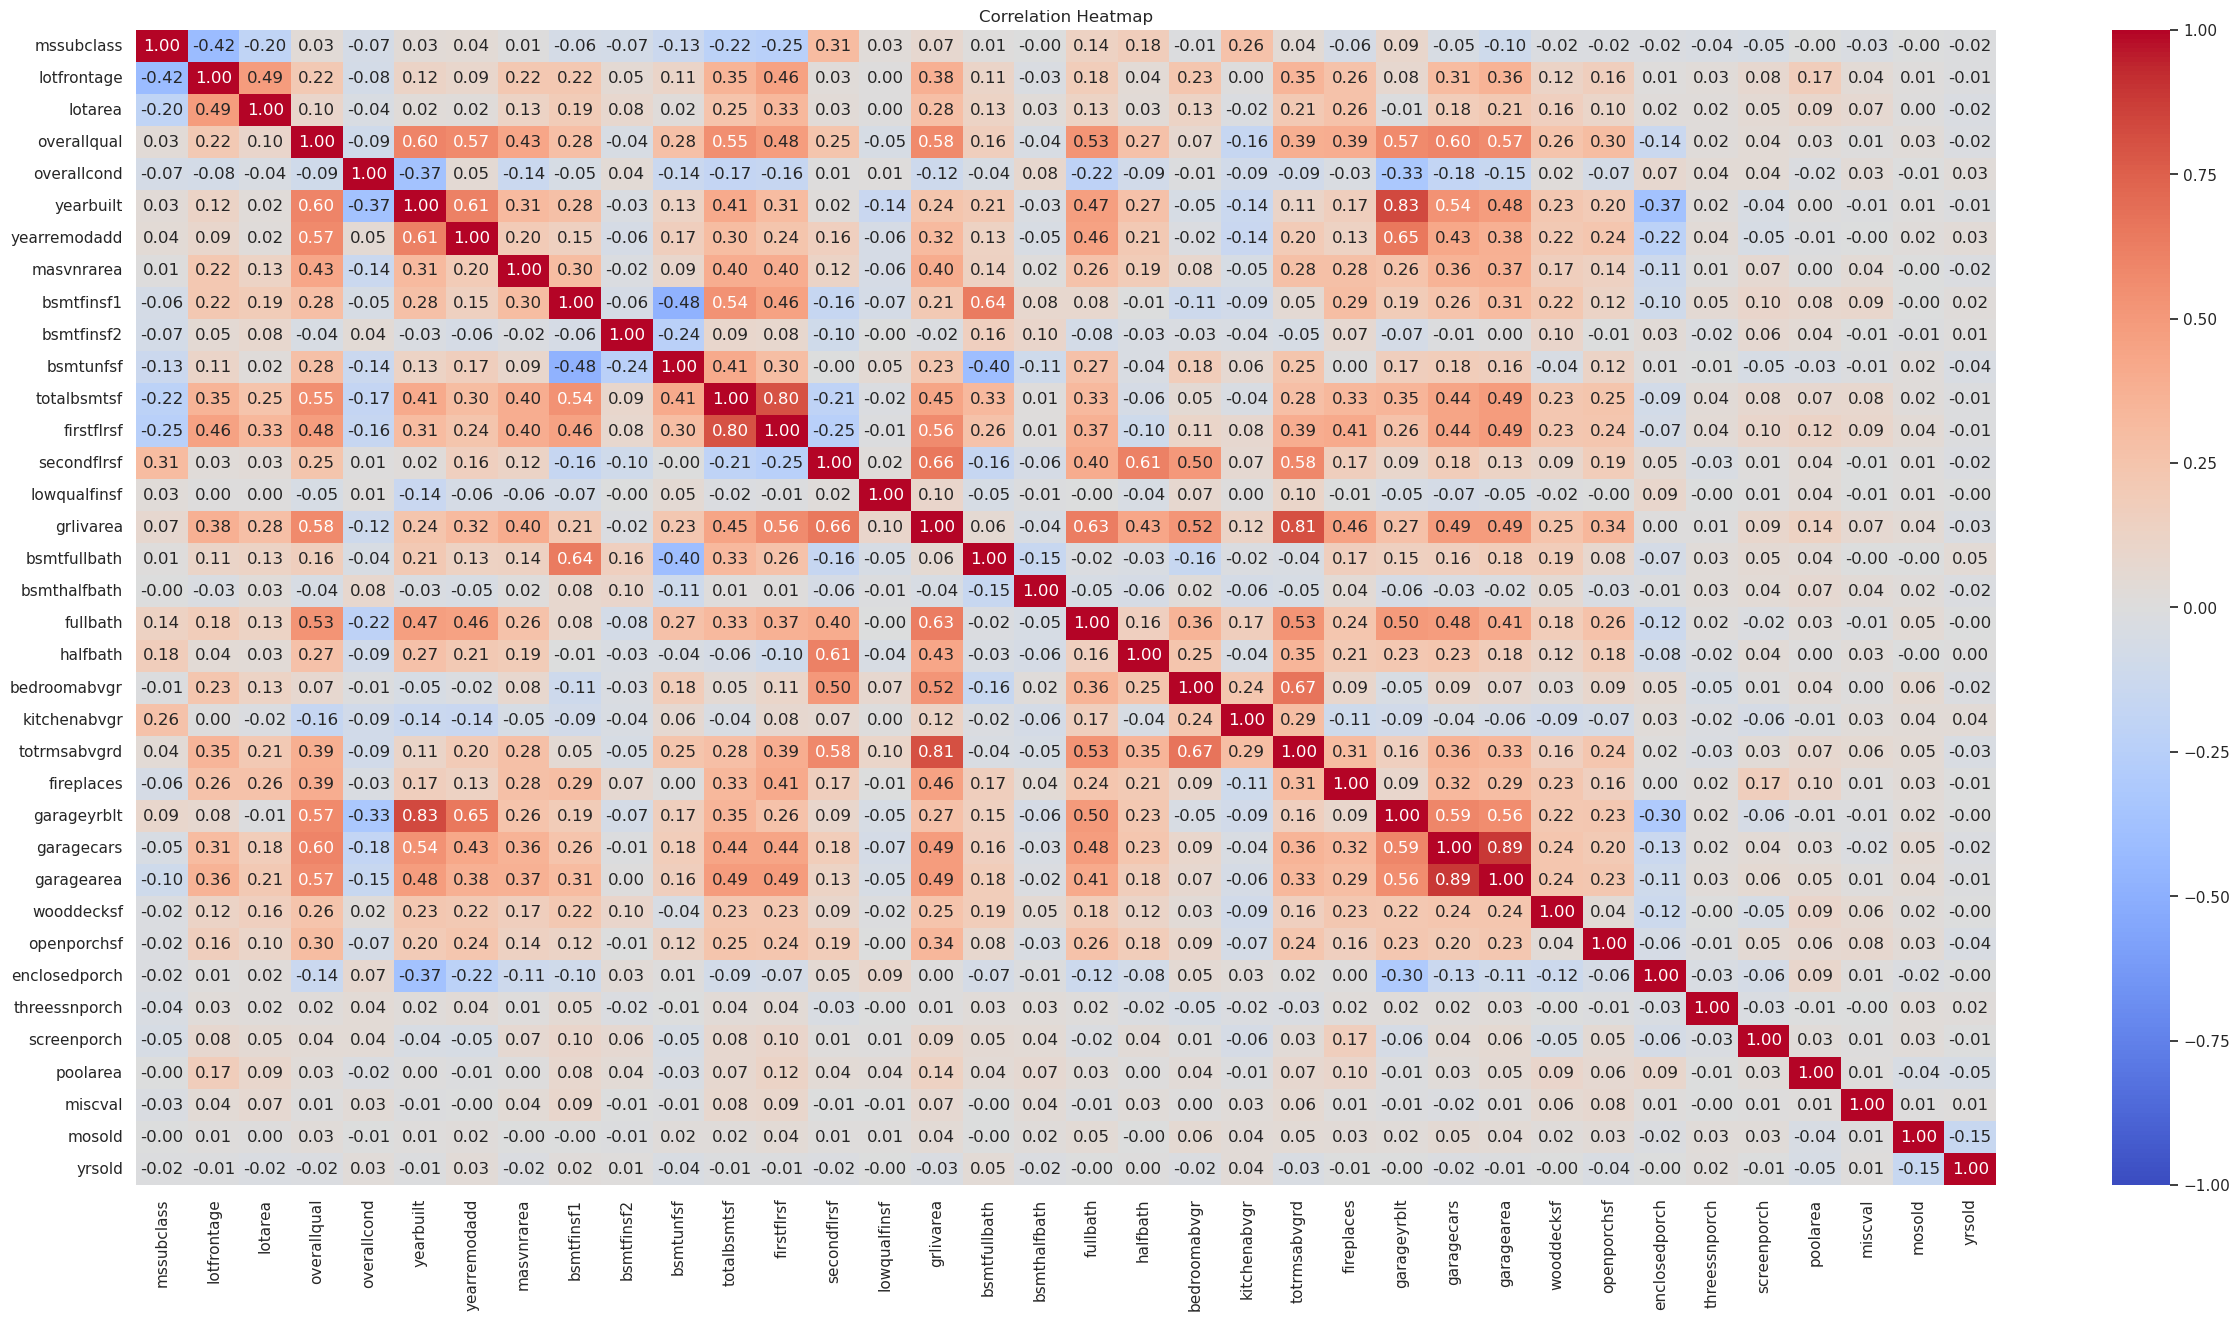

In [14]:
# Correlation matrix
corr_matrix = df_num.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Review Categorical Columns

In [15]:
# select only the numerical features
df_cat = df.select_dtypes(include = ['object'])

# print shape of dataset
shape = df_cat.shape
print("Shape of the dataframe (row, col):",shape,"\r\n")

# show first 5 rows of data frame
df_cat.head()

Shape of the dataframe (row, col): (2919, 43) 



,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,,,,WD,Normal
1,RL,Pave,,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,,,,WD,Normal
2,RL,Pave,,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,,,,WD,Normal
3,RL,Pave,,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,,,,WD,Abnorml
4,RL,Pave,,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,,,,WD,Normal


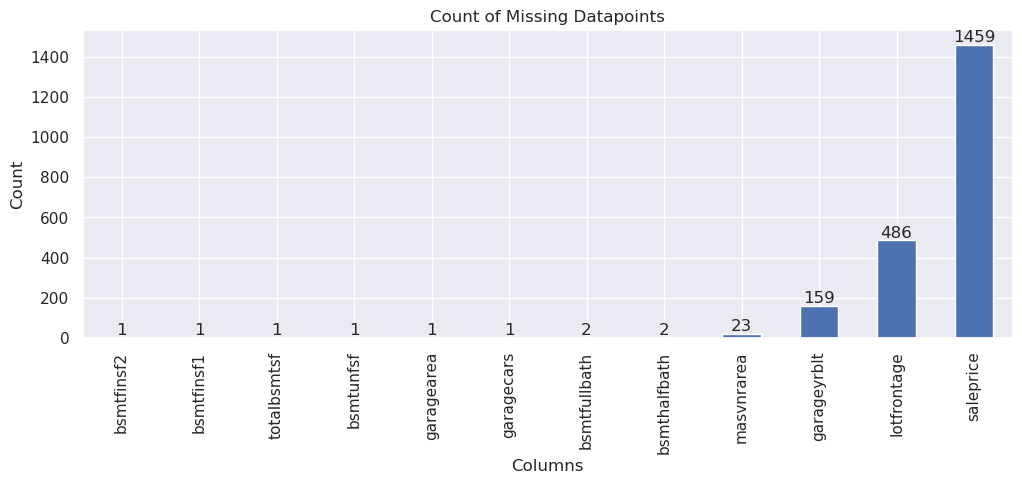

In [16]:
# find and plot how many missing values each column has
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)


plt.figure(figsize=(12, 4))
missing.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Count of Missing Datapoints')

# Displaying the count of the bars above each bar
for i, v in enumerate(missing):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

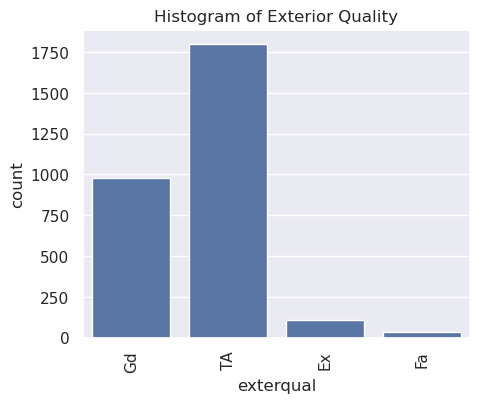

In [17]:
# plot exterior quality
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='exterqual')
plt.title(f'Histogram of Exterior Quality')
plt.xticks(rotation=90)
plt.show()

## Shut down notebook resources

In [18]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

In [19]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>